<a href="https://colab.research.google.com/github/voquangtuong/DL_Tutorial/blob/master/GOOD_v2_outdubaogiadaugoi_motbien_nhieubuocdaura_NDIscatter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import os
# creat the output folder 
out_dirs=['out_fig_kb1','out_tab_kb1','out_kb1']
for out_dir in out_dirs:
  if not os.path.exists(out_dir):
    os.makedirs(out_dir)


In [65]:
import os
os.chdir('/content/drive/MyDrive/droughtprediction/code_systematics')

In [66]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = 8, 6 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [67]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]

	X = X.reshape(X.shape[0], 1, X.shape[1])
	# reshape training into [samples, timesteps, features]
	loss_all, val_loss_all = list(), list()
	# X = X.reshape(X.shape[0], 1, X.shape[1])   
  
	# design network
	model = Sequential() 

 
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))  

	# model.add(Dense(10)) 
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	callbacks_stop=[EarlyStopping(monitor='loss',patience=10)] 
	# fit network
  
	for i in range(nb_epoch):
		history=model.fit(X, y, epochs=3, batch_size=n_batch, verbose=1, shuffle=False,callbacks=callbacks_stop)
		# history=model.fit(X, y, epochs=50, batch_size=n_batch, verbose=1, shuffle=False)  
		loss_all.append(history.history['loss'])
		# val_loss_all.append(history.history['val_loss'])
		model.reset_states()
	return model, loss_all
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	rmse_all=list()  
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
		rmse_all.append(rmse) 
	return rmse_all
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()


Epoch 1/3
389/389 [==============================] - 2s 2ms/step - loss: 0.0804
Epoch 2/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0782
Epoch 3/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0768
Epoch 1/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0849
Epoch 2/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0847
Epoch 3/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0847
Epoch 1/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0846
Epoch 2/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0846
Epoch 3/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0846
Epoch 1/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0846
Epoch 2/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0846
Epoch 3/3
389/389 [==============================] - 1s 2ms/step - loss: 0.0845
Epoch 1/3
389/389 [=====================

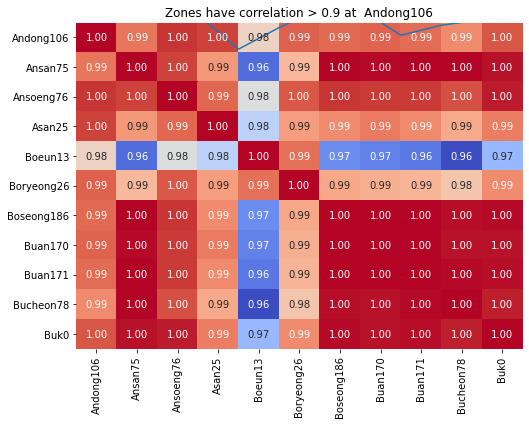

In [68]:
 # In[9]:
dataset1000=pd.read_csv("input_data/percentile_season_adj.csv")
# dataset0.describe()
# dataset00.head()
# # chuyen data tu 2001/01-2019/12
# dataset0=dataset00.iloc[6:-4,0:]
# dataset0.reset_index(drop=True,inplace=True)
# dataset0
# =============================================================================
# Arrange predicted column
list1 = dataset1000.columns.tolist()
# for k in range(1,len(list1)):
    #  check station 1
k=1  
list2=list1[0:1]+list1[k:]+list1[1:k]
# print(list2)
# Using indent to control loop of station
# dataset=dataset0[list2]
# dataset.describe()
# modified dataset
# print(list2)
# Using indent to control loop of station
# dataset100=dataset0[list2]
# dataset.describe()
dataset0=dataset1000[list2] # avoid dataset0 not change
corr = dataset0.corr()
df=corr
df2 = df[df.columns[df.iloc[0,:] > 0.9]]
df2
list3=df2.columns.tolist()
list3.insert(0,'Date')
dataset=dataset0[list3]
dataset0=dataset # avoid dataset0 not change
fig0=plt.Figure()
plt.Figure(figsize=[8,6])
corr1 = dataset.corr()
# corr1.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
# plt.title("Zones have correlation > 0.9 at  "+list1[k])
# plt.tight_layout()
# plt.savefig(output_fig+"\\"+list1[k]+"Corel"+".png",dpi=300)
fig=plt.Figure(figsize=(8,6))
fig, ax = plt.subplots()
sns.heatmap(dataset.corr(method='pearson'), annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
# ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.title("Zones have correlation > 0.9 at  "+list1[k])
plt.savefig(out_dirs[0]+"/"+list1[k]+"Corel"+".png",dpi=300, bbox_inches='tight', pad_inches=0.0)

corr1.to_csv(out_dirs[1]+"/"+list1[k]+"cor"+".csv")
    # =============================================================================

# load dataset
df=dataset
# df=read_csv('input_data/percentile_101.csv')
series=df.iloc[:,1]
# series = read_csv('shampoo.txt', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 6
n_test = 36
n_epochs = 20
n_batch = 1
n_neurons = 10
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model, loss_all = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)


# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# # evaluate forecasts
# evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)
# import numpy as np
# for i in range(3):
  
#   np.array(actual)[:,i]
#   import matplotlib.pyplot as plt
#   plt.subplot()
#   ax=plt.plot(np.array(actual)[:,i],'-.bo')
#   np.array(forecasts)[:,i]
#   bx=plt.plot(np.array(forecasts)[:,i],'-.ro')
#   plt.title('prediction for next'+str(i+1)+'month')
#   plt.legend(['obs','pred'])
#   plt.xlabel('months')
#   plt.ylabel('NDI')
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# fig = make_subplots(rows=3, cols=1)

# fig.add_trace(
#     go.Scatter(x=np.array(range(len(actual))), y=np.array(actual)[:,0]),
    
#     row=1, col=1
# )
# fig.add_trace(
#     go.Scatter(x=np.array(range(len(forecasts))), y=np.array(forecasts)[:,0]),
    
#     row=1, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.array(range(len(actual))), y=np.array(actual)[:,1]),
    
#     row=2, col=1
# )
# fig.add_trace(
#     go.Scatter(x=np.array(range(len(forecasts))), y=np.array(forecasts)[:,1]),
    
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatter(x=np.array(range(len(actual))), y=np.array(actual)[:,2]),
    
#     row=3, col=1
# )
# fig.add_trace(
#     go.Scatter(x=np.array(range(len(forecasts))), y=np.array(forecasts)[:,2]),
    
#     row=3, col=1
# )



t+1 RMSE: 0.621147
t+2 RMSE: 0.622506
t+3 RMSE: 0.612484
t+4 RMSE: 0.648689
t+5 RMSE: 0.676156
t+6 RMSE: 0.680673


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

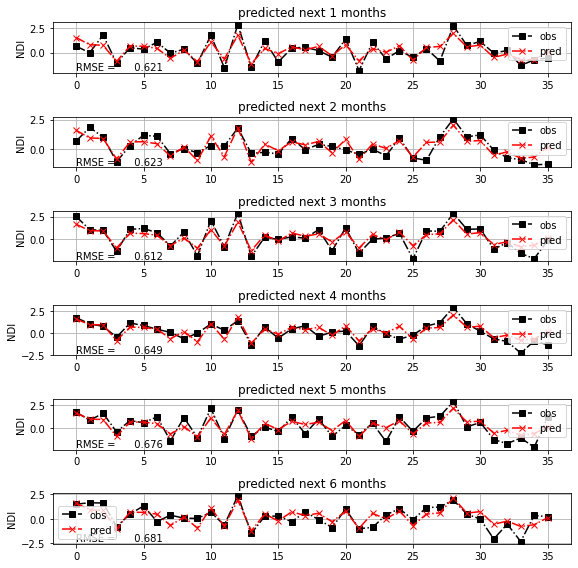

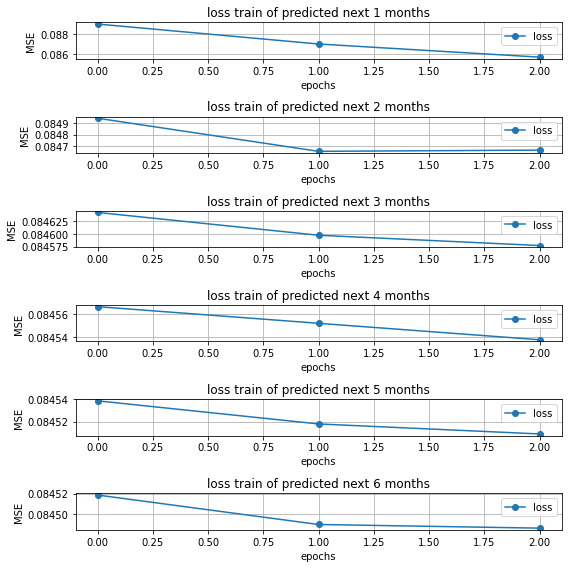

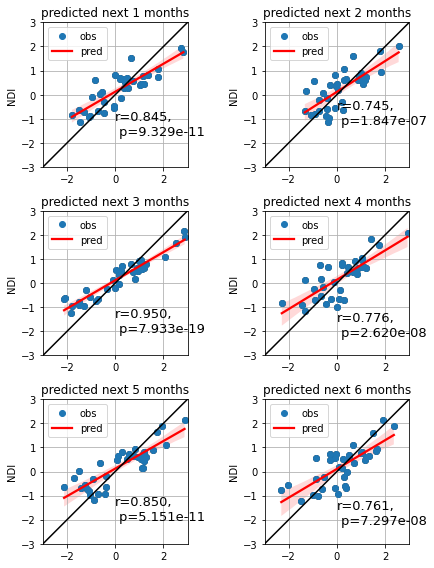

In [71]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
# time = np.linspace(0, 10, 1000)
# height = np.sin(time)
# weight = time*0.3 + 2
# score = time**2 + height
# distribution = np.random.normal(0, 1, len(time))
# fig = plt.figure(figsize=(10, 5))
# gs = GridSpec(nrows=3, ncols=1)
# ax0 = fig.add_subplot(gs[0, 0])
# ax0=plt.plot(np.array(actual)[:,0],'-.s')
# ax0=plt.plot(np.array(forecasts)[:,0],'-.ro')
# ax1 = fig.add_subplot(gs[1, 0])
# ax1=plt.plot(np.array(actual)[:,1],'-.^')
# ax1=plt.plot(np.array(forecasts)[:,1],'-.x')
# ax2 = fig.add_subplot(gs[2, 0])
# ax2=plt.plot(np.array(actual)[:,2],'-.*')
# ax2=plt.plot(np.array(forecasts)[:,2],'-.+')

# plt.show()
# using loop
month_names=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
# evaluate forecasts
rmse_all=evaluate_forecasts(actual, forecasts, n_lag, n_seq)
fig = plt.figure(figsize=(8, 8))
# plt.subplots(3,1,sharex=True)
gs = GridSpec(nrows=n_seq, ncols=1)
for j in range(n_seq):
  ax = fig.add_subplot(gs[j, 0])
  ax=plt.plot(np.array(actual)[:,j],'-.s',color='black') #'-.s'
  ax=plt.plot(np.array(forecasts)[:,j],'-.x',color='red') #'-.ro'
#   ax=plt.text(0,np.array(actual)[:,j].min(),'RMSE = '+str(rmse_all[j]))
#   ax=plt.text(0,np.array(actual)[:,j].min(),'RMSE = '+ '{:10.3f}'.format(rmse_all[j]))  
  ax=plt.text(0,np.array(actual)[:,j].min(),'RMSE = '+ '%10.3f' %rmse_all[j])  
  # plt.title('predicted the '+ month_names[j]+' of next year')
  plt.title('predicted next '+str(j+1)+' months')
  plt.grid(None)
  # plt.xlabel('months')
  plt.ylabel('NDI')
  plt.legend(['obs','pred'])
  
plt.tight_layout()
# plt.savefig(out_dirs[0]+'/'+str(n_seq)+'_months_pred.png',dpi=300,bbox_inches='tight')
plt.savefig(out_dirs[0]+'/'+str(n_seq)+'_months_pred.png',dpi=300)
# plt.show()



fig = plt.figure(figsize=(8, 8))
# plt.subplots(3,1,sharex=True)
gs = GridSpec(nrows=n_seq, ncols=1)
for j in range(n_seq):
  ax = fig.add_subplot(gs[j, 0])
#   ax=plt.plot(np.array(loss_all)[:,j],'-') #'-.s'
  ax=plt.plot(loss_all[j][:],'-o') #'-.s'
#   ax=plt.plot(np.array(forecasts)[:,j],'-.x') #'-.ro'
  # plt.title('predicted the '+ month_names[j]+' of next year')
  plt.title('loss train of predicted next '+str(j+1)+' months')
  plt.grid(None)
  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.legend(['loss'])
plt.tight_layout()
plt.savefig(out_dirs[0]+'/'+str(n_seq)+'_months_pred_loss_train.png',dpi=300)
import matplotlib.lines as mlines

# save prediction resutls
df_forecast=pd.DataFrame(forecasts)
df_actual=pd.DataFrame(actual)
df_test=pd.concat([df_forecast,df_actual],axis=1)
df_test.to_csv(out_dirs[2]+'/'+list2[k]+'test'+'.csv')

fig = plt.figure(figsize=(8, 8))
# plt.subplots(3,1,sharex=True)
gs = GridSpec(nrows=int(n_seq/2), ncols=2)
jjj=0
for j in range(int(n_seq/2)):
  for jj in range(2):
    jjj+=1
    corr = pearsonr(np.array(actual)[:,jjj-1], np.array(forecasts)[:,jjj-1])
    # corr = [np.round(c, 2) for c in corr]
    #add the coefficient to your graph
    text = 'r=%4.3f,\n p=%4.3e' % (corr[0], corr[1]) 
    ax = fig.add_subplot(gs[j, jj])
    ax=plt.plot(np.array(actual)[:,jjj-1],np.array(forecasts)[:,jjj-1],'o')
    ax=sns.regplot(np.array(actual)[:,jjj-1],np.array(forecasts)[:,jjj-1],scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    # plt.title("Compare prediction and observation")
    plt.text(0,np.array(actual)[:,jjj-1].min()+0.1, text, fontsize=13)
    # plt.title('predicted the '+ month_names[j]+' of next year')
    plt.title('predicted next '+str(jjj)+' months')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.grid(True)
    
    # plt.xlabel('months')
    plt.ylabel('NDI')
    plt.legend(['obs','pred'])
    # plt.axis('equal')
    # plt.axis('square')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.draw()
    plt.tight_layout()
plt.tight_layout()   
# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig("filename.pdf", bbox_inches = 'tight',
#     pad_inches = 0) 
# plt.savefig(out_dirs[0]+'/'+str(n_seq)+'_months_pred_scatter.png',dpi=300,bbox_inches='tight')
plt.savefig(out_dirs[0]+'/'+str(n_seq)+list2[k]+'_months_pred_scatter.png',dpi=300,bbox_inches='tight')
# plt.show()
pd.DataFrame(rmse_all).to_csv(out_dirs[1]+'/'+str(n_seq)+list2[k]+'_months_pred_err.csv')
# # Download figures
# from google.colab import files
# # files.download(out_dirs[0]+'/'+str(n_seq)+'_months_pred.png')
# files.download(out_dirs[0]+'/'+str(n_seq)+'_months_pred_scatter.png')
# save 36 months prediction to file
